# 06: 阈值分割

# 目标
* 使用固定阈值、自适应阈值和 Otsu 阈值法"二值化"图像
* OpenCV 函数：cv2.threshold(), cv2.adaptiveThreshold()

# 教程

固定阈值分割

固定阈值分割很直接，一句话说就是像素点值大于阈值变成一类值，小于阈值变成另一类值。

In [1]:
import cv2
img=cv2.imread('./imgs/gradient.jpg',0)

ret,th=cv2.threshold(img,127,255,cv2.THRESH_BINARY)
cv2.imshow('thresh',th)
cv2.waitKey(0)

-1

cv2.threshold()用来实现阈值分割，ret 是 return value 缩写，代表当前的阈值，暂时不用理会。函数有 4 个参数：

* 参数 1：要处理的原图，一般是灰度图
* 参数 2：设定的阈值
* 参数 3：对于THRESH_BINARY、THRESH_BINARY_INV阈值方法所选用的最大阈值，一般为 255
* 参数 4：阈值的方式，主要有 5 种，详情：ThresholdTypes
https://docs.opencv.org/4.0.0/d7/d1b/group__imgproc__misc.html#gaa9e58d2860d4afa658ef70a9b1115576

下面结合代码理解下这 5 种阈值方式：

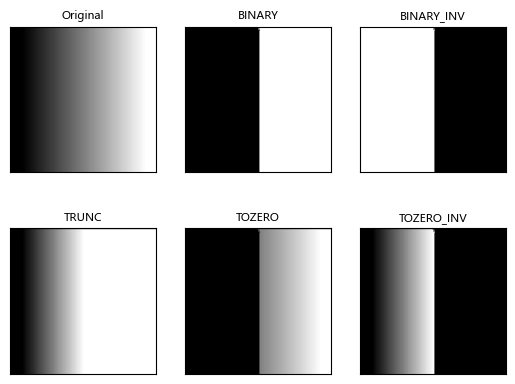

In [2]:
import matplotlib.pyplot as plt

ret,th1=cv2.threshold(img,127,255,cv2.THRESH_BINARY)
ret,th2=cv2.threshold(img,127,255,cv2.THRESH_BINARY_INV)
ret,th3=cv2.threshold(img,127,255,cv2.THRESH_TRUNC)
ret,th4=cv2.threshold(img,127,255,cv2.THRESH_TOZERO)
ret,th5=cv2.threshold(img,127,255,cv2.THRESH_TOZERO_INV)

titles = ['Original', 'BINARY', 'BINARY_INV', 'TRUNC', 'TOZERO', 'TOZERO_INV']
images = [img, th1, th2, th3, th4, th5]

for i in range(6):
  plt.subplot(2,3,i+1)
  plt.imshow(images[i],'gray')
  plt.title(titles[i],fontsize=8)
  plt.xticks([])
  plt.yticks([])

plt.show()

经验之谈：很多人误以为阈值分割就是二值化。从上图中可以发现，两者并不等同，阈值分割结果是两类值，而不是两个值，所以教程开头我把二值化加了引号。
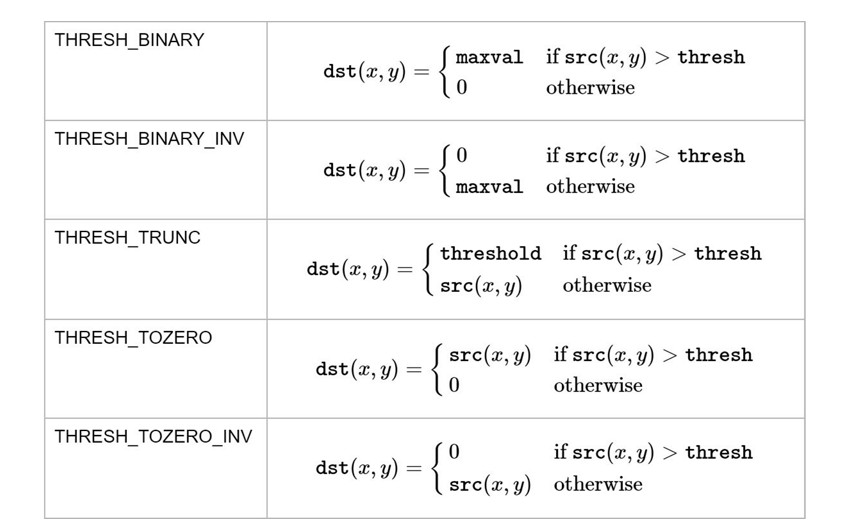

# 自适应阈值
看得出来固定阈值是在整幅图片上应用一个阈值进行分割，它并不适用于明暗分布不均的图片。 cv2.adaptiveThreshold()自适应阈值会每次取图片的一小部分计算阈值，这样图片不同区域的阈值就不尽相同。它有 5 个参数，其实很好理解，先看下效果：

* 参数 1：要处理的原图
* 参数 2：最大阈值，一般为 255
* 参数 3：小区域阈值的计算方式
ADAPTIVE_THRESH_MEAN_C：小区域内取均值
ADAPTIVE_THRESH_GAUSSIAN_C：小区域内加权求和，权重是个高斯核
* 参数 4：阈值方法，只能使用THRESH_BINARY、THRESH_BINARY_INV，具体见前面所讲的阈值方法
* 参数 5：小区域的面积，如 11 就是 11*11 的小块
* 参数 6：最终阈值等于小区域计算出的阈值再减去此值

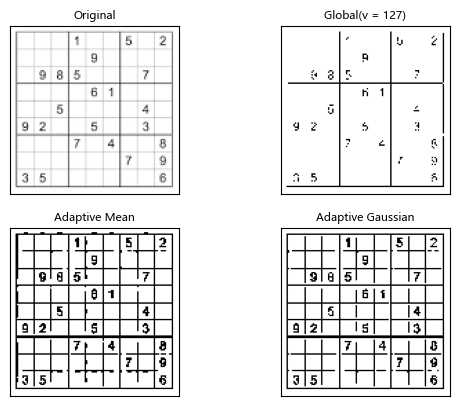

In [39]:
img=cv2.imread('./imgs/suduko.png',0)

ret,th1=cv2.threshold(img,127,255,cv2.THRESH_BINARY)
th2=cv2.adaptiveThreshold(img,255,cv2.ADAPTIVE_THRESH_MEAN_C,cv2.THRESH_BINARY,9,9)
th3=cv2.adaptiveThreshold(img,255,cv2.ADAPTIVE_THRESH_GAUSSIAN_C,cv2.THRESH_BINARY,11,10)

titles = ['Original', 'Global(v = 127)', 'Adaptive Mean', 'Adaptive Gaussian']
images = [img, th1, th2, th3]

for i in range(4):
  plt.subplot(2,2,i+1)
  plt.imshow(images[i],'gray')
  plt.title(titles[i],fontsize=8)
  plt.xticks([])
  plt.yticks([])
plt.show()


# Otsu 阈值
在前面固定阈值中，我们是随便选了一个阈值如 127，那如何知道我们选的这个阈值效果好不好呢？答案是：不断尝试，所以这种方法在很多文献中都被称为经验阈值。Otsu 阈值法就提供了一种自动高效的二值化方法，不过我们直方图还没学，这里暂时略过。

# 小结
* cv2.threshold()用来进行固定阈值分割。固定阈值不适用于光线不均匀的图片，所以用 cv2.adaptiveThreshold()进行自适应阈值分割。
* 二值化跟阈值分割并不等同。针对不同的图片，可以采用不同的阈值方法。

# 练习
Otsu 阈值是一种高效的二值化算法

# 番外篇：Otsu 阈值法
大部分图像处理任务都需要先进行二值化操作，阈值的选取很关键，Otsu 阈值法会自动计算阈值。

Otsu 阈值法（日本人大津展之提出的，也可称大津算法）非常适用于双峰图片，啥意思呢？
https://ieeexplore.ieee.org/stamp/stamp.jsp?arnumber=4310076
 
# 什么是双峰图片？
双峰图片就是指图片的灰度直方图上有两个峰值，直方图就是每个值（0~255）的像素点个数统计，后面会详细介绍。
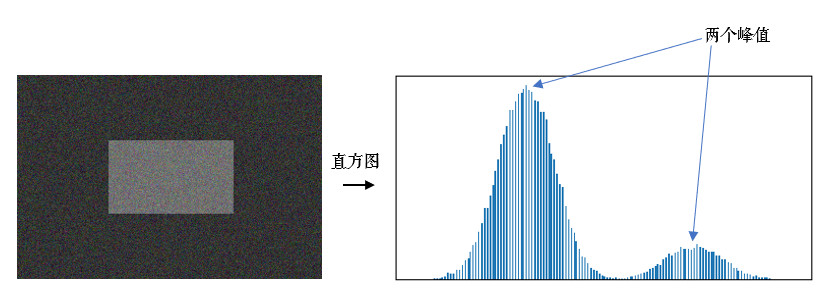
Otsu 算法假设这副图片由前景色和背景色组成，通过统计学方法（最大类间方差）选取一个阈值，将前景和背景尽可能分开，我们先来看下代码，然后详细说明下算法原理。

# 代码示例
下面这段代码对比了使用固定阈值和 Otsu 阈值后的不同结果：

另外，对含噪点的图像，先进行滤波操作效果会更好。

In [41]:
import cv2
from matplotlib import pyplot as plt

img=cv2.imread('./imgs/noisy.jpg',0)

# 固定阈值法
ret1,th1=cv2.threshold(img,100,255,cv2.THRESH_BINARY)

# Otsu 阈值法
ret2,th2=cv2.threshold(img,0,255,cv2.THRESH_BINARY+cv2.THRESH_OTSU)

# 先进行高斯滤波，再使用 Otsu 阈值法
blur = cv2.GaussianBlur(img, (5, 5), 0)
ret3, th3 = cv2.threshold(blur, 0, 255, cv2.THRESH_BINARY + cv2.THRESH_OTSU)

下面我们用 Matplotlib 把原图、直方图和阈值图都显示出来：

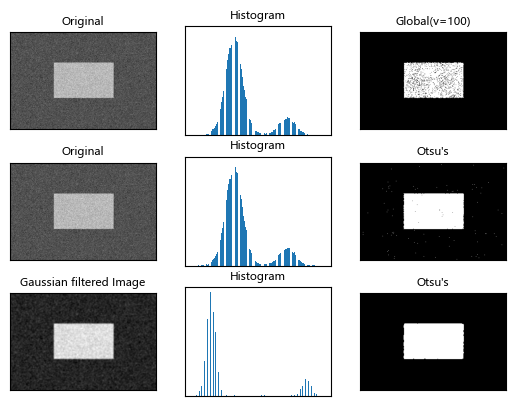

In [42]:
images = [img, 0, th1, img, 0, th2, blur, 0, th3]
titles = ['Original', 'Histogram', 'Global(v=100)',
          'Original', 'Histogram', "Otsu's",
          'Gaussian filtered Image', 'Histogram', "Otsu's"]

for i in range(3):
    # 绘制原图
    plt.subplot(3, 3, i * 3 + 1)
    plt.imshow(images[i * 3], 'gray')
    plt.title(titles[i * 3], fontsize=8)
    plt.xticks([]), plt.yticks([])

    # 绘制直方图 plt.hist，ravel 函数将数组降成一维
    plt.subplot(3, 3, i * 3 + 2)
    plt.hist(images[i * 3].ravel(), 256)
    plt.title(titles[i * 3 + 1], fontsize=8)
    plt.xticks([]), plt.yticks([])

    # 绘制阈值图
    plt.subplot(3, 3, i * 3 + 3)
    plt.imshow(images[i * 3 + 2], 'gray')
    plt.title(titles[i * 3 + 2], fontsize=8)
    plt.xticks([]), plt.yticks([])
plt.show()

可以看到，Otsu 阈值明显优于固定阈值，省去了不断尝试阈值判断效果好坏的过程。其中，绘制直方图时，使用了 numpy 中的ravel()函数，它会将原矩阵压缩成一维数组，便于画直方图。

# Otsu 算法详解
Otsu 阈值法将整幅图分为前景（目标）和背景，以下是一些符号规定：

* $ T $：分割阈值
* $ N_0 $：前景像素点数
* $ N_1 $：背景像素点数
* $ \omega_0 $：前景的像素点数占整幅图像的比例
* $ \omega_1 $：背景的像素点数占整幅图像的比例
* $ \mu_0 $：前景的平均像素值
* $ \mu_1 $：背景的平均像素值
* $ \mu $：整幅图的平均像素值
* $ rows\times cols $：图像的行数和列数
结合下图会更容易理解一些，有一副大小为 4×4 的图片，假设阈值 T 为 1，那么：
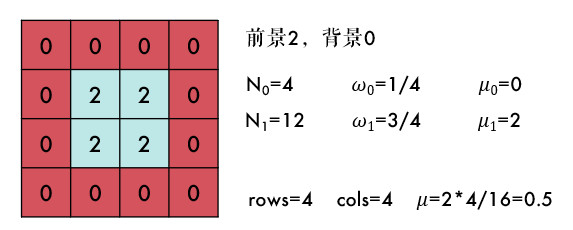
其实很好理解，$ N_0+N_1 $就是总的像素点个数，也就是行数乘列数：
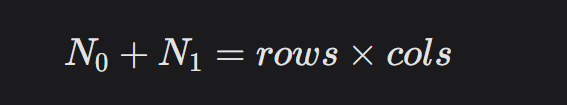
$ \omega_0 和 \omega_1 $是前/背景所占的比例，也就是：
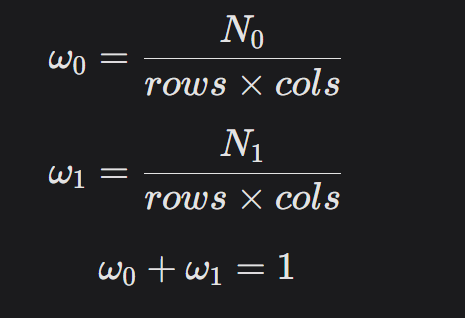
整幅图的平均像素值就是：
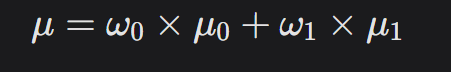
此时，我们定义一个前景$ \mu_0 与背景 \mu_1 的方差 g $：
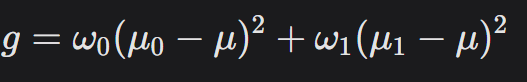
将前述的 1/2/3 公式整合在一起，便是：
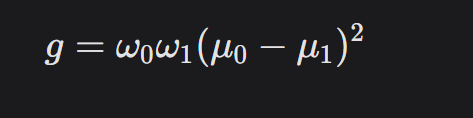
$ g  就是前景与背景两类之间的方差，这个值越大，说明前景和背景的差别也就越大，效果越好。Otsu算法便是遍历阈值T，使得 g $最大，所以又称为最大类间方差法。基本上双峰图片的阈值 T 在两峰之间的谷底。